# Health Insurance | Job-A-Thon
Author: Miguel Santana

### Project Methodology
FinMan Company is looking to leverage their client base by cross selling insurance products to existing customers. Insurance policies are offered to prospective and existing clients based on website landing and consumer election to fill out additional information forms. FinMan company would like to leverage their acquired information to classify positive leads for outreach programs using machine learning classifiers. 

### Data and Analytical Structure
The project dataset is provided by Analytics Vidhya via Kaggle. Data includes demographic features, policy features (for current customers) and example positive classifications for ML model validation and interpretation. The source can be found [here.](https://www.kaggle.com/imsparsh/jobathon-analytics-vidhya?select=sample_submission.csv) The project analysis will follow the OSEMN framework: Obtain, Scrub, Explore, Model and Interpret.

## Data & Packages
**OBTAIN**

run pycaret first, then go to next two using scikit learn, then neural net

<div class="alert alert-success">

**NOTE HERE**

</div>

<div class="alert alert-block alert-info">

**NOTE HERE**

</div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.set_option('display.max_columns',50)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('train.csv')

In [4]:
print(df.shape)
df.head(3)

(50882, 14)


,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1


## Data Cleaning
**SCRUB**

### Missing Values

In [5]:
df.isnull().sum()

ID                             0
City_Code                      0
Region_Code                    0
Accomodation_Type              0
Reco_Insurance_Type            0
Upper_Age                      0
Lower_Age                      0
Is_Spouse                      0
Health Indicator           11691
Holding_Policy_Duration    20251
Holding_Policy_Type        20251
Reco_Policy_Cat                0
Reco_Policy_Premium            0
Response                       0
dtype: int64

<div class="alert alert-success">

With many of these prospects not clearly identified as current clients, its safe to assume that null values in the 'Policy Duration' and 'Policy Type' columns are tied to non existing accounts and may be filled with zeros.

</div> 

In [6]:
# df = df[df['Reco_Insurance_Type']=='Individual']
# df.drop(['ID','Region_Code','Reco_Insurance_Type','Lower_Age','Is_Spouse'],axis=1,inplace=True)

**Filling Null Values**

In [7]:
nonclients = ['Holding_Policy_Duration','Holding_Policy_Type']

for col in nonclients:
    df[col] = df[col].fillna(0)

In [8]:
# df['Health Indicator'].mode()[0]

<div class="alert alert-success">

Null values in the 'Health Indicator' columns will be filled prior to one hot encoding. 

</div>

### Feature Conversions

In [9]:
# df.select_dtypes('O').columns

<div class="alert alert-success">
Convert to numerical: Holding_Policy_Duration
    
* Feature engineer long term customers
* Convert '14+' to '15' / convert to numerical

Note: (**after EDA**) Convert to binary | Accomodation_Type, Reco_Insurance_Type, Is_Spouse
</div>

#### Categorical Features | Feature Engineering

In [10]:
df['Long_Term_Cust'] = df['Holding_Policy_Duration'].apply(lambda x: 'Yes' if x == '14+' else 'No')
df['Holding_Policy_Duration'] = df['Holding_Policy_Duration'].replace('14+',15).astype(float).astype(int)

#### Binary Feature Conversion

<div class="alert alert-block alert-info">
    
Features 'Accomodation Type', 'Reco Insurance Type', 'Is Spouse' will be converted to binary (0 and 1) after our exploratory data analysis. 

</div>

#### Numerical Feature Conversion

In [11]:
# df.select_dtypes('number').columns

<div class="alert alert-block alert-info">
    
The two feature that stand out are 'Holding Policy Type' and 'Reco Policy Cat' which are listed under numerical but most likely correspond to type and category of policy in existing customers. As such, the features will be converted to categorical variables and compared against the policy premium during exploratory data analysis. 

</div>

### Feature Engineering | Age
<div class="alert alert-success">

Typically, insurance products are priced and underwritten based on the age of the applicant or applicants. This is especially the case in most health insurance pricing. To reflect this and retain data, an average age feature will be created and the original two features will be dropped. As the data shows, individual insurance types reflect the same age for lower and upper categories. This conversion will only effect joint accounts with large variations in age being represented in the 'Is_Spouse' feature which will be converted to binary after EDA. For aesthetics, the category will be renamed 'Married'.

</div>

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  int64  
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  int64  
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Lower_Age                50882 non-null  int64  
 7   Is_Spouse                50882 non-null  object 
 8   Health Indicator         39191 non-null  object 
 9   Holding_Policy_Duration  50882 non-null  int64  
 10  Holding_Policy_Type      50882 non-null  float64
 11  Reco_Policy_Cat          50882 non-null  int64  
 12  Reco_Policy_Premium      50882 non-null  float64
 13  Response                 50882 non-null  int64  
 14  Long_Term_Cust        

In [13]:
# Conversion
df.rename(columns={'Is_Spouse':'Married'},inplace=True)
# # Average Age
# df['Avg_Age'] = df['Upper_Age']+df['Lower_Age']
# df['Avg_Age'] = df['Avg_Age']/2

### Dropping Features

In [14]:
print(f'Unique policy types: {len(df.Holding_Policy_Type.value_counts())}')
print(f'Unique policy categories: {len(df.Reco_Policy_Cat.value_counts())}')
print(f'Unique city codes: {len(df.City_Code.value_counts())}')
print(f'Unique region codes: {len(df.Region_Code.value_counts())}')

Unique policy types: 5
Unique policy categories: 22
Unique city codes: 36
Unique region codes: 5316


<div class="alert alert-success">

The unique 'ID' and 'Region Code' columns will be dropped in order to simplify the data. 'Region Code' consists of far too many categorical values which would need to be one hot encoded. The feature is dropped as the data still retains the 'City Code' feature to capture some level of geographical distinction. In addition, the upper and lower age features will be dropped being represented by average age. 

</div>

In [15]:
df.drop(['ID','Region_Code'],axis=1,inplace=True)
# df.drop(['ID','Region_Code','Upper_Age','Lower_Age'],axis=1,inplace=True)

#### Health Indicator Missing Values

In [16]:
joint = len(df[ (df['Health Indicator'].isnull()) & (df['Reco_Insurance_Type']=='Joint')])
indiv = len(df[ (df['Health Indicator'].isnull()) & (df['Reco_Insurance_Type']=='Individual')])

print(f'There are {joint} missing Health Indicators with joint policy types.')
print(f'There are {indiv} missing Health Indicators with individual policy types.')

There are 2349 missing Health Indicators with joint policy types.
There are 9342 missing Health Indicators with individual policy types.


<div class="alert alert-success">

The missing health indicators in the joint policy types represent less than 5% of the dataset and will be dropped. The remaining values will be filled using the mode. 

</div>

In [17]:
# dropping partial nulls
indexvals = df[ (df['Health Indicator'].isnull()) & (df['Reco_Insurance_Type']=='Joint')].index
df.drop(indexvals, inplace=True)

In [18]:
# filling remaining nulls
df['Health Indicator'] = df['Health Indicator'].fillna(df['Health Indicator'].mode()[0])

In [19]:
# numerical conversion / float to int
for col in df.select_dtypes('number').columns:
    df[col] = df[col].astype(int)

In [20]:
# sns.catplot(data=df, x='Reco_Policy_Premium',y='Health Indicator')

## Exploratory Data Analysis

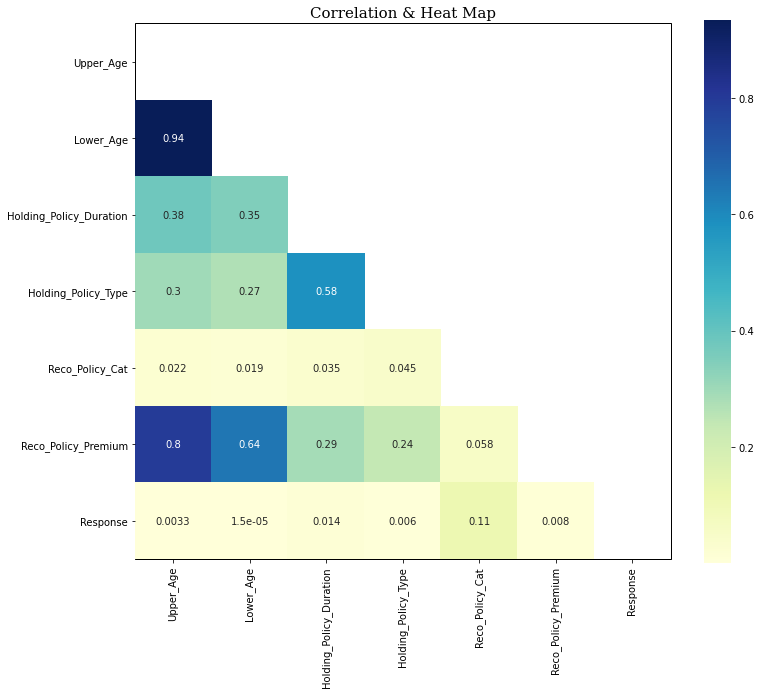

In [21]:
corr = df.corr() # analyzing correlation
fig, ax = plt.subplots(figsize=(12,10))
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, mask=mask, square=True, annot=True, cmap='YlGnBu')
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('1')
ax.set_title('Correlation & Heat Map', fontsize=15, fontfamily='serif')
plt.show()

In [22]:
# sns.countplot(data=df[df['Holding_Policy_Type']!=0],x='Holding_Policy_Type',hue='Response')

In [23]:
# sns.violinplot(data=df[df['Holding_Policy_Duration']!=0],x='Holding_Policy_Duration',y='Avg_Age')

In [24]:
# sns.violinplot(data=df[df['Holding_Policy_Type']!=0],x='Holding_Policy_Type',y='Avg_Age',hue='Response')

<div class="alert alert-block alert-info">

**NOTE HERE**

</div>

### Final Updates
* Binary Conversions: 'Accomodation_Type', 'Reco_Insurance_Type' and 'Married'
* Numerical Conversions: 'Holding Policy Type' and 'Reco Policy Cat' 
* Final conversions for ML modeling

In [25]:
# # Exporting for dashboard analysis
# df.to_csv('testtesttest.csv')

In [26]:
df.head()

,City_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Married,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,Long_Term_Cust
0,C3,Rented,Individual,36,36,No,X1,15,3,22,11628,0,Yes
1,C5,Owned,Joint,75,22,No,X2,0,0,22,30510,0,No
2,C5,Owned,Individual,32,32,No,X1,1,1,19,7450,1,No
3,C24,Owned,Joint,52,48,No,X1,15,3,19,17780,0,Yes
4,C8,Rented,Individual,44,44,No,X2,3,1,16,10404,0,No


Binary Conversion

In [27]:
vals = {'Rented':1,'Owned':2,'Individual':1,'Joint':2,'No':0,'Yes':1}
cols = ['Accomodation_Type','Reco_Insurance_Type','Married','Long_Term_Cust']

for col in cols:
    df[col] = df[col].replace(vals)

Numerical Conversion

In [28]:
# Converting ordinal features to categories
ordinal = ['Holding_Policy_Type','Reco_Policy_Cat']
for col in ordinal:
    df[col] = df[col].astype('O')

Final ML Model Updates

In [29]:
ordinaldf = df[['Holding_Policy_Type','Reco_Policy_Cat','Reco_Policy_Premium']].copy()
# ohedf = pd.DataFrame(df['City_Code','Health Indicator'])
ohedf = df[['City_Code','Health Indicator']].copy()
df.drop(['Holding_Policy_Type','Reco_Policy_Cat','City_Code','Health Indicator'],axis=1,inplace=True)

In [30]:
# List | categorical variables in ordinal columns
cat_vars = [var for var in ordinaldf.columns if ordinaldf[var].dtype == 'O']

In [31]:
def replace_categories(df, var, target):
    # Order variable categories | lowest to highest against target (price)
    ordered_labels = df.groupby([var])[target].mean().sort_values().index

    # Dictionary of ordered categories to integer values
    ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}

    # Replace the categorical strings by integers using dictionary
    df[var] = df[var].map(ordinal_label)

In [32]:
# Ordinal variable conversion
for var in cat_vars:
    replace_categories(ordinaldf, var, 'Reco_Policy_Premium')

#### one hot encode

In [33]:
# One Hot Encode
ohedf = pd.get_dummies(ohedf,drop_first=True)

In [34]:
# Concatenate / ohedf,ordinaldf its the ordinal conversions/actually its the math age
dataset = pd.concat([df,ohedf,ordinaldf],axis=1)

# dataset = df.copy()

In [35]:
ordinaldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48533 entries, 0 to 50881
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Holding_Policy_Type  48533 non-null  int64
 1   Reco_Policy_Cat      48533 non-null  int64
 2   Reco_Policy_Premium  48533 non-null  int64
dtypes: int64(3)
memory usage: 1.5 MB


In [36]:
# Converting uint8 datatypes back to categorical variables 
for cat_cols in dataset.select_dtypes('uint8').columns:
    dataset[cat_cols] = dataset[cat_cols].astype('category')

In [37]:
# Fixing Column Names
# cleaning column names
subs = [(' ', '_'),('.0','')]

def col_formatting(col):
    '''Replacing Column Features for Model Processing'''
    for old, new in subs:
        col = col.replace(old,new)
    return col

dataset.columns = [col_formatting(col) for col in dataset.columns]

#### Pycaret

In [38]:
# dataset = data.copy()

In [39]:
# dataset.info()

In [40]:
import pycaret
import pycaret.preprocess as preprocess
from pycaret.datasets import get_data
from pycaret.classification import *
import pycaret.preprocess as preprocess

In [41]:
data = dataset.sample(frac=0.80, random_state=786)
data_unseen = dataset.drop(data.index).reset_index(drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (38826, 55)
Unseen Data For Predictions: (9707, 55)


In [42]:
testpycar = setup(data=data,target='Response',fix_imbalance=True,session_id=123,normalize=True,n_jobs=-1,feature_ratio=False,use_gpu=True)

IntProgress(value=0, description='Processing: ', max=13)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,18:16:49
Status,. . . . . . . . . . . . . . . . . .,Preparing Data for Modeling
ETC,. . . . . . . . . . . . . . . . . .,Calculating ETC


Error importing optional module geopandas
Traceback (most recent call last):
  File "/Users/miguelsantana/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/_plotly_utils/optional_imports.py", line 30, in get_module
    return import_module(name)
  File "/Users/miguelsantana/opt/anaconda3/envs/learn-env/lib/python3.6/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 994, in _gcd_import
  File "<frozen importlib._bootstrap>", line 971, in _find_and_load
  File "<frozen importlib._bootstrap>", line 955, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 665, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/miguelsantana/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/geopandas/__init__.py", line 1, in <module>

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [ ]:
data.info()

In [ ]:
# clf1 = setup(data=data,target='Response',session_id=123,numeric_features=['Accomodation_Type','Reco_Insurance_Type','Married','Holding_Policy_Duration','Holding_Policy_Type'])

In [ ]:
# clf1 = setup(data=data,target='Response',session_id=123,numeric_features=['Accomodation_Type','Reco_Insurance_Type','Married','Health Indicator','Holding_Policy_Duration','Holding_Policy_Type'])

# HERE

In [ ]:
data.info()

In [ ]:
compare_models()

In [ ]:
# GBC = create_model('gbc')
# tuned_GBC = tune_model(GBC, optimize = 'AUC')
# print(tuned_GBC)
# plot_model(tuned_GBC, plot = 'auc')
# plot_model(tuned_GBC, plot = 'confusion_matrix')
# # Final check using the unseen data / test
# predict_model(tuned_GBC);

# # Final Model / trained on the complete dataset
# final_GBC = finalize_model(tuned_GBC)

# evaluate_model(final_GBC)

# plot_model(final_GBC, plot='feature')

# # Interpret model | SHAP
# interpret_model(final_GBC)

In [ ]:
#### neural network

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense,Dropout
# from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# early_stop = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=25)

In [ ]:
# model = Sequential()

# model.add(Dense(21,activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(18,activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(15,activation='relu'))
# model.add(Dropout(0.5))

# # Binary Classification
# model.add(Dense(1,activation='sigmoid'))

# model.compile(loss='binary_crossentropy',optimizer='adam')

In [ ]:
# model.fit(x=X_train,y=y_train,epochs=500,validation_data=(X_test,y_test),
#           callbacks=[early_stop])

In [ ]:
# model_loss = pd.DataFrame(model.history.history)
# model_loss.plot(figsize=(10,6));

In [ ]:
# model.summary()

In [ ]:
# # model.predict_classes(X_test)
# predictions = model.predict_classes(X_test)

In [ ]:
# print(classification_report(y_test,predictions))

In [ ]:
# # separate city for dummy variables
# citydf = df['City_Code']
# # citydf = pd.Dataframe(df['City_Code'])
# city = citydf.to_frame()